In [1]:
#https://www.kaggle.com/werty12121/utkface-age-and-sex-prediction
import numpy as np
import pandas as pd 
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

from vgg16_gender import VGG_16_2
import torch
import torch.optim as optim
import torch.nn as nn
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:

def imshow(img):
    plt.imshow(img, interpolation='bicubic')
    plt.xticks([]), plt.yticks([]) 
    plt.show()

In [7]:
device = torch.device("cpu")

In [4]:
test_batch = 1024
train_batch = 128
onlyfiles = os.listdir("/home/name/UTKFace")
y = np.array([[[i.split('_')[1]],[i.split('_')[2]]] for i in onlyfiles])#gender and race
# y = np.array([[i.split('_')[1] for i in onlyfiles]]).T
print(y.shape)
#print(y)
print(y[2])

(23708, 2, 1)
[['1']
 ['0']]


In [5]:
X_data =[]
for file in onlyfiles:
    face = cv2.imread("/home/name/UTKFace/"+file,cv2.IMREAD_COLOR)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face =cv2.resize(face, (32,32) )
    X_data.append(face)
X_data=np.array(X_data)
X_data.shape

(23708, 32, 32, 3)

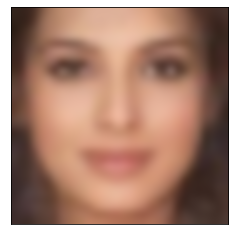

[['0']
 ['1']]


In [6]:
X = np.squeeze(X_data)
imshow(X[1])
print(y[0])

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
y_train=[y_train[:,1],y_train[:,0]]
y_train = [int(i) for i in y_train[:][1]] 
y_valid=[y_valid[:,1],y_valid[:,0]]
y_valid = [int(i) for i in y_valid[:][1]] 
X_train = X_train.astype('float32')/255 
X_valid = X_valid.astype('float32')/255



X_train=np.moveaxis(X_train, -1, 1)
X_valid=np.moveaxis(X_valid, -1, 1)


In [8]:
print(X_train[1].shape)
print(len(y_valid))

(3, 32, 32)
7824


In [9]:
print(X_train.min())

0.0


In [10]:
print(y_train[:])

[1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 

In [11]:

def test_(model, criterion):
    
    SNR=[]
    model.eval()
    total_correct = 0
    avg_loss = 0.0
    maxi = 0
    count =0
    for i in range (0, X_valid.shape[0], test_batch):
        inputs, target = torch.Tensor(X_valid[i:i+test_batch, :]).to(device), torch.LongTensor(y_valid[i:i+test_batch]).reshape(len(y_valid[i:i+test_batch])).to(device)
        output, _ = model(inputs)
        loss = criterion(output,target)
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(target.view_as(pred)).sum()
        print(i, loss)
        avg_loss += loss
        del inputs
        del target
        count = i
    avg_loss /= count
    #print("MAX", maxi)
    print(float(total_correct)/X_valid.shape[0])
    print('Test Avg. Loss:, Accuracy: %f' % avg_loss)

    return (float(total_correct)/X_valid.shape[0])

In [12]:

def test(model, criterion):
    
    SNR=[]
    model.eval()
    total_correct = 0
    avg_loss = 0.0
    maxi = 0
    count =0
    for i in range (0, X_valid.shape[0], test_batch):
        inputs, target = torch.Tensor(X_valid[i:i+test_batch, :]).to(device), torch.LongTensor(y_valid[i:i+test_batch]).reshape(len(y_valid[i:i+test_batch])).to(device)
        output = model(inputs)
        loss = criterion(output,target)
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(target.view_as(pred)).sum()
        print(i, loss)
        #print(torch.mean(model.intermed.scales()))
        
        avg_loss += loss
        del inputs
        del target
        count = i
    avg_loss /= count
    #print("MAX", maxi)
    print(float(total_correct)/X_valid.shape[0])
    print('Test Avg. Loss:, Accuracy: %f' % avg_loss)




In [13]:

def test_mask(model, criterion, mask):
    
    SNR=[]
    model.eval()
    total_correct = 0
    avg_loss = 0.0
    maxi = 0
    count =0
    for i in range (0, X_valid.shape[0], test_batch):
        inputs, target = torch.Tensor(X_valid[i:i+test_batch, :]).to(device), torch.LongTensor(y_valid[i:i+test_batch]).reshape(len(y_valid[i:i+test_batch])).to(device)
        inputs = inputs*mask
        output = model(inputs)
        loss = criterion(output,target)
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(target.view_as(pred)).sum()
        print(i, loss)
        print(torch.mean(model_syn.intermed.scales()))
        
        avg_loss += loss
        del inputs
        del target
        count = i
    avg_loss /= count
    #print("MAX", maxi)
    print(float(total_correct)/X_valid.shape[0])
    print('Test Avg. Loss:, Accuracy: %f' % avg_loss)





In [14]:
def test_stoch(model,criterion, iterations = 10):
    count = 0
    for i in range (iterations):
        count += test_(model, criterion)
    return float(count)/iterations

In [9]:
def train_(model, criterion, increase = False, coef = 1):
    model.train()
    total_correct =0
    for i in range (0, X_train.shape[0], train_batch):

        optimizer.zero_grad()
       
        inputs, target = torch.Tensor(X_train[i:i+train_batch, :]).to(device),  torch.LongTensor(y_train[i:i+train_batch]).reshape(len(y_train[i:i+train_batch])).to(device)
       
        output, _ = model(inputs)
        print(output.shape)
        print(target.shape)
        if (not increase):
            loss = criterion(output,target)
        if (increase):
            loss = criterion(output,target) - coef*torch.log(torch.mean((model.intermed.scales())))+10
            
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(target.view_as(pred)).sum()
        print(float(total_correct)/(i+train_batch), "acc")
        print(torch.mean(model_syn.intermed.scales()), "mean")
        print(total_correct, i+train_batch)
        print(loss, "loss")
        if (i%4096==0):
            print ("____________________loss")
            
            
            test_(model,criterion)
            
        del inputs
        del target
        loss.backward()
        optimizer.step()

       

In [4]:
criterion = torch.nn.CrossEntropyLoss()

In [5]:
model = VGG_16_2()
#model.to(device)

In [8]:
model.load_state_dict(torch.load('UTKFace-gender-norm', map_location=torch.device(device)))

<All keys matched successfully>

In [20]:
test(model, criterion)

0 tensor(0.2908, grad_fn=<NllLossBackward>)
1024 tensor(0.2913, grad_fn=<NllLossBackward>)
2048 tensor(0.3008, grad_fn=<NllLossBackward>)
3072 tensor(0.2838, grad_fn=<NllLossBackward>)
4096 tensor(0.2759, grad_fn=<NllLossBackward>)
5120 tensor(0.3329, grad_fn=<NllLossBackward>)
6144 tensor(0.2626, grad_fn=<NllLossBackward>)
7168 tensor(0.2401, grad_fn=<NllLossBackward>)
0.8787065439672802
Test Avg. Loss:, Accuracy: 0.000318


# Noisy Network

In [21]:

class NoisyActivation(nn.Module):
    def __init__(self,  given_locs, given_scales, min_scale, max_scale):
        super(NoisyActivation, self).__init__()
        size = given_scales.shape
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.given_locs = given_locs 
        self.given_scales = given_scales
        self.locs = nn.Parameter(torch.Tensor(size).copy_(self.given_locs))         
        self.rhos = nn.Parameter(torch.ones(size)-5) #-inf


        self.normal = torch.distributions.normal.Normal(0,1)
        self.rhos.requires_grad = True
        self.locs.requires_grad = True
        
    def scales(self):
        return (1.0 +torch.tanh(self.rhos))/2*(self.max_scale-self.min_scale) +self.min_scale             
    
    def sample_noise(self):
        epsilon = self.normal.sample(self.rhos.shape)
        return self.locs + self.scales() * epsilon
                                 
                               
                            
    def forward(self, input):
        noise = self.sample_noise()
        return (input) + noise



class vgg_syn(nn.Module):

    def __init__(self, model_features, model_classifier, min_scale,max_scale, given_locs, given_scale):
        super(vgg_syn, self).__init__()
        

        self.intermed = NoisyActivation( given_locs, given_scale, min_scale, max_scale)
        self.model_pt2 =  torch.nn.Sequential(*(list(model_features)))
        self.model_pt3 = model_classifier
        #self.components = components
        for child in itertools.chain(self.model_pt2, self.model_pt3): #self.model_pt2 #(self.model_pt2, 
            for param in child.parameters():
                param.requires_grad = False
            if isinstance(child, nn.modules.batchnorm._BatchNorm):
                child.eval()
                child.affine = False
                child.track_running_stats = False
                
        self.intermed.rhos.reuires_grad = True
        self.intermed.locs.reuires_grad = True
                                 
    def forward(self, img):
                                 
        
        x = self.intermed(img)
        noisy = x.detach()
         
        x = self.model_pt2(x)                    
        x = x.view(img.size(0), -1)
        x = self.model_pt3(x)                                 

        return x, noisy
    
                                 
 






In [22]:
import math
import itertools
mus = torch.zeros((3,32,32))
scale = torch.ones((3,32,32))*0.01
model_syn = vgg_syn(model.convnet, model.fc ,0.0001, 1.5 ,mus, scale )
model_syn.to(device)

vgg_syn(
  (intermed): NoisyActivation()
  (model_pt2): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False

In [23]:
criterion = nn.CrossEntropyLoss().to(device)

In [24]:

print(torch.mean(model_syn.intermed.scales()))
print(torch.max(model_syn.intermed.scales()))
print(torch.min(model_syn.intermed.scales()))

tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MaxBackward1>)
tensor(0.0006, grad_fn=<MinBackward1>)


In [26]:
model_syn.load_state_dict(torch.load('UTKFace-gender-cloak', map_location=torch.device("cpu")))

<All keys matched successfully>

In [27]:
d = list(filter(lambda p: p.requires_grad, model_syn.parameters()))
print(len(d))

2


In [ ]:
lr = 0.01 #3 lr 0.01 coef 10/2 lr 0.001 False/3 lr 0.01 coef 10/ 22 lr 0.001 False/3  lr 0.01 coef 10/17 lr 0.005 False/ 2 lr. 0.01 coef 10/ 20 lr 0.005 False
for epoch in range(2):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_syn.parameters()), lr=lr, weight_decay=0)
    #print(model.convnet[0].weight)
    print (epoch, "epoch!")
    train_(model_syn,criterion, True, 10)
    

In [34]:

acc=test_stoch(model_syn,criterion,10)
print (acc)

0 tensor(0.5165, grad_fn=<NllLossBackward>)
1024 tensor(0.5637, grad_fn=<NllLossBackward>)
2048 tensor(0.5316, grad_fn=<NllLossBackward>)
3072 tensor(0.5313, grad_fn=<NllLossBackward>)
4096 tensor(0.8201, grad_fn=<NllLossBackward>)
5120 tensor(0.5825, grad_fn=<NllLossBackward>)
6144 tensor(0.6047, grad_fn=<NllLossBackward>)
7168 tensor(0.5217, grad_fn=<NllLossBackward>)
0.7027096114519428
Test Avg. Loss:, Accuracy: 0.000652
0 tensor(0.5365, grad_fn=<NllLossBackward>)
1024 tensor(0.6237, grad_fn=<NllLossBackward>)
2048 tensor(0.5070, grad_fn=<NllLossBackward>)
3072 tensor(0.5049, grad_fn=<NllLossBackward>)
4096 tensor(0.5098, grad_fn=<NllLossBackward>)
5120 tensor(0.6077, grad_fn=<NllLossBackward>)
6144 tensor(0.6781, grad_fn=<NllLossBackward>)
7168 tensor(0.5176, grad_fn=<NllLossBackward>)
0.7083333333333334
Test Avg. Loss:, Accuracy: 0.000626
0 tensor(0.6486, grad_fn=<NllLossBackward>)
1024 tensor(0.5304, grad_fn=<NllLossBackward>)
2048 tensor(0.5290, grad_fn=<NllLossBackward>)
3072 t